In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#下載檔案(不包含Weather)
import pandas as pd
from glob import glob

data = pd.read_csv("/content/drive/My Drive/專題研究💪/VRP/demand.csv")
loc = pd.read_csv("/content/drive/My Drive/專題研究💪/VRP/location.csv")

In [7]:
import numpy as np
import math
import csv
import pandas as pd
from math import sqrt
from math import cos
from math import sin


np.set_printoptions(threshold = 1e6)


# df = pd.read_csv('test.csv')
# df.columns = ["stop", "need"]

need = data[["need"]]
need = np.array(need)

snn = data[["stop", "need"]]
snn = np.array(snn)

# df = pd.read_csv('test_latlon.csv')
# df.columns = ["stop", "lat", "lon"]

lat = loc["lat"]
lat = np.array(lat)

lon = loc["lon"]
lon = np.array(lon)

location = loc[["lat", "lon"]]
location = np.array(location)


count = 0
for a in range(20):     # a in range num of all city
    if need[count] == 0:
        snn = np.delete(snn, count, 0)
        need = np.delete(need, count, 0)
        lat = np.delete(lat, count, 0)
        lon = np.delete(lon, count, 0)
        continue
    else:
        count = count + 1


NUM_CITY = count

NUM_POINT = 20  #預設每條路線最大長度



def rad(d):
    return d * math.pi / 180.0

def getDistance(lat1, lng1, lat2, lng2):
    EARTH_REDIUS = 6378.137
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(sin(a / 2), 2) + cos(radLat1) * cos(radLat2) * math.pow(sin(b / 2), 2)))
    s = s * EARTH_REDIUS
    # print("distance=", s, "km")
    return s


c = (NUM_CITY + 1, NUM_CITY + 1)
dist = np.zeros(c, dtype=float)

for aa in range(NUM_CITY + 1):
    for bb in range(NUM_CITY + 1):
        dist[aa][bb] = getDistance(lat[aa], lon[aa], lat[bb], lon[bb])


NUM_VEHICLE = 3

MAX_WEIGHT = 30  # 最大載重

INIT_WEIGHT = 15   # 初始載重

NUM_ITERATION = 1000

NUM_CHROME = 20  # 染色體個數

NUM_BIT = NUM_CITY  # 染色體長度

Pc = 0.8  # 交配率 (代表共執行Pc*NUM_CHROME/2次交配)
Pm = 0.1  # 突變率 (代表共要執行Pm*NUM_CHROME*NUM_BIT次突變)

NUM_PARENT = NUM_CHROME  # 父母的個數
NUM_CROSSOVER = int(Pc * NUM_CHROME / 2)  # 交配的次數
NUM_CROSSOVER_2 = NUM_CROSSOVER * 2  # 上數的兩倍
NUM_MUTATION = int(Pm * NUM_CHROME * NUM_BIT)  # 突變的次數

np.random.seed(0)  # 若要每次跑得都不一樣的結果，就把這行註解掉


def initPop():  # 初始化群體
    p1 = []
    p = (NUM_CHROME, 2 * NUM_VEHICLE)
    p2 = np.zeros(p, dtype=float)

    for i in range(NUM_CHROME):

        p1.append(np.random.permutation(range(1 ,NUM_CITY+1)))

        for k in range(2 * NUM_VEHICLE):
            if k % 2 == 0:
                p2[i][k] = np.random.uniform(38.88, 38.92)    # 突變的地方也要改
            else:
                p2[i][k] = np.random.uniform(-77.01, -77.04)

    return p1, p2


def fitFunc(x1, x2):
    vtotal = 0
    v_dist = np.zeros((NUM_VEHICLE,), dtype=float)
    pre_city = np.zeros((NUM_VEHICLE,), dtype=int)
    weight = np.full((NUM_VEHICLE,), INIT_WEIGHT)
    route = np.zeros([NUM_VEHICLE, NUM_POINT], dtype=int)
    
    for i in range(NUM_BIT):  # 站點分給每一台車
        j = np.argmin([math.hypot(location[x1[i]][0] - x2[2 * k], location[x1[i]][1] - x2[2 * k + 1]) for k in range(NUM_VEHICLE)])
        v_dist[j] += dist[pre_city[j]][x1[i]]
        pre_city[j] = x1[i]

        for a in range(NUM_POINT):      # 將站點記錄起來
            if route[j][a] == 0:
                route[j][a] = x1[i]
                break

    for i in range(NUM_VEHICLE):  # 加上回到起點的距離
        v_dist[i] += dist[pre_city[i]][0]

    for i in range(NUM_VEHICLE):
        for j in range(NUM_POINT):  #算即時載重
          if route[i][j] != 0:
            weight[i] = weight[i] + need[route[i][j] - 1]
            if weight[i] < 0 or weight[i] > MAX_WEIGHT:
              v_dist[i] = 100000
          else:
            break

    for i in range(NUM_VEHICLE):  # 算總距離
        vtotal += v_dist[i]


    return -(vtotal)  # 回傳總路徑長


def evaluatePop(p1, p2):  # 評估群體之適應度
    return [fitFunc(p1[i], p2[i]) for i in range(len(p1))]  #len(p1) = 20


def selection(p1, p2, p_fit):  # 用二元競爭式選擇法來挑父母
    a1 = []
    a2 = []

    for i in range(NUM_PARENT):
        [j, k] = np.random.choice(NUM_CHROME, 2, replace=False)  # 任選兩個index
        if p_fit[j] > p_fit[k]:  # 擇優
            a1.append(p1[j].copy())
            a2.append(p2[j].copy())
        else:
            a1.append(p1[k].copy())
            a2.append(p2[k].copy())

    return a1, a2


def crossover_uniform(p1, p2):  # 用均勻交配來繁衍子代
    a1 = []
    a2 = []

    for i in range(NUM_CROSSOVER):
        mask1 = np.random.randint(2, size=NUM_BIT)
        mask2 = np.random.randint(2, size=2 * NUM_VEHICLE)

        [j, k] = np.random.choice(NUM_PARENT, 2, replace=False)  # 任選兩個index

        child1, child2 = p1[j].copy(), p1[k].copy()
        remain1, remain2 = list(p1[j].copy()), list(p1[k].copy())  # 存還沒被用掉的城市

        for m in range(NUM_BIT):
            if mask1[m] == 1:
                remain2.remove(child1[m])  # 砍掉 remain2 中的值是 child1[m]
                remain1.remove(child2[m])  # 砍掉 remain1 中的值是 child2[m]

        t = 0
        for m in range(NUM_BIT):
            if mask1[m] == 0:
                child1[m] = remain2[t]
                child2[m] = remain1[t]
                t += 1

        a1.append(child1)
        a1.append(child2)

        # === for p2 ===
        child3, child4 = p2[j].copy(), p2[k].copy()

        for m in range(2 * NUM_VEHICLE):
            if mask2[m] == 1:
                child3[m] = p2[k][m]
                child4[m] = p2[j][m]

        a2.append(child3)
        a2.append(child4)

    return a1, a2


def mutation(p1, p2):  # 突變
    for _ in range(NUM_MUTATION):
        row = np.random.randint(NUM_CROSSOVER_2)  # 任選一個染色體

        if np.random.randint(2) == 0:
            [j, k] = np.random.choice(NUM_BIT, 2, replace=False)  # 任選兩個基因

            p1[row][j], p1[row][k] = p1[row][k], p1[row][j]  # 此染色體的兩基因互換
        else:
            j = np.random.randint(2 * NUM_VEHICLE)  # 任選1個基因
            if j % 2 == 0:
                p2[row][j] = np.random.uniform(38.88, 38.92)
            else:
                p2[row][j] = np.random.uniform(-77.01, -77.04)


def sortChrome(a1, a2, a_fit):  # a的根據a_fit由大排到小
    a_index = range(len(a1))  # 產生 0, 1, 2, ..., |a|-1 的 list

    a_fit, a_index = zip(*sorted(zip(a_fit, a_index), reverse=True))  # a_index 根據 a_fit 的大小由大到小連動的排序

    return [a1[i] for i in a_index], [a2[i] for i in a_index], a_fit  # 根據 a_index 的次序來回傳 a，並把對應的 fit 回傳


def replace(p1, p2, p_fit, a1, a2, a_fit):
    b1 = np.concatenate((p1, a1), axis=0)  # 把本代 p 和子代 a 合併成 b
    b2 = np.concatenate((p2, a2), axis=0)  # 把本代 p 和子代 a 合併成 b
    b_fit = p_fit + a_fit  # 把上述兩代的 fitness 合併成 b_fit

    b1, b2, b_fit = sortChrome(b1, b2, b_fit)  # b 和 b_fit 連動的排序

    return b1[:NUM_CHROME], b2[:NUM_CHROME], list(b_fit[:NUM_CHROME])  # 回傳 NUM_CHROME 個為新的一個世代


def printRoute(x1, x2):

    route = np.zeros([NUM_VEHICLE, NUM_POINT], dtype=int)

    v_dist = np.zeros((50,), dtype=float)
    pre_city = np.zeros((50,), dtype=int)
    for i in range(NUM_BIT):
        j = np.argmin([math.hypot(location[x1[i]][0] - x2[2 * k], location[x1[i]][1] - x2[2 * k + 1]) for k in range(NUM_VEHICLE)])
        v_dist[j] += dist[pre_city[j]][x1[i]]
        pre_city[j] = x1[i]

        for a in range(NUM_POINT):
            if route[j][a] == 0:
                route[j][a] = x1[i]
                break

    print(route)

    return



pop1, pop2 = initPop()
pop_fit = evaluatePop(pop1, pop2)
print(pop1)
print(pop2)
print(-max(pop_fit))    #初始fit value

best_outputs = []
best_outputs.append(np.max(pop_fit))

mean_outputs = []
mean_outputs.append(np.average(pop_fit))

for i in range(NUM_ITERATION):
    parent1, parent2 = selection(pop1, pop2, pop_fit)
    offspring1, offspring2 = crossover_uniform(parent1, parent2)
    mutation(offspring1, offspring2)
    offspring_fit = evaluatePop(offspring1, offspring2)
    pop1, pop2, pop_fit = replace(pop1, pop2, pop_fit, offspring1, offspring2, offspring_fit)

    best_outputs.append(np.max(pop_fit))
    mean_outputs.append(np.average(pop_fit))
    # print(pop1)
    # print(pop2)
    # print(pop_fit)

    if i != NUM_ITERATION - 1:
        print('iteration %d: y = %f' % (i, -pop_fit[0]))
    else:
        print('iteration %d: \nx1 = %s, \n\nx2 = %s, \n\n車輛總距離 = %f\n' % (i, pop1[0], pop2[0], -pop_fit[0]))
        printRoute(pop1[0], pop2[0])

    # if i != NUM_ITERATION - 1:
    #     print('%d, %f, %f' % (i, -pop_fit[0], -mean_outputs[i]))
    # else:
    #     print('%d, %f, %f \n\nx1 = %s, \n\nx2 = %s' % (i, -pop_fit[0], -mean_outputs[i], pop1[0], pop2[0]))
    #     printRoute(pop1[0], pop2[0])


[array([ 7, 12,  5, 11,  3,  9,  2,  8, 10,  4,  1,  6, 13]), array([11,  2,  7,  8,  3, 13,  6, 12,  1,  4,  5, 10,  9]), array([ 6,  2, 10,  7,  1,  9, 12, 13,  3,  4,  8,  5, 11]), array([ 5, 12,  6,  1, 11,  3,  9,  7,  4, 10,  8, 13,  2]), array([10,  7,  8,  2,  1,  6,  3, 13, 11,  9, 12,  5,  4]), array([ 9,  7, 13,  5, 12, 10,  2,  6,  8,  1, 11,  3,  4]), array([ 8,  9,  7,  6,  1, 13, 10, 12, 11,  3,  2,  5,  4]), array([ 2,  5,  6, 10,  7, 11,  8, 13,  1, 12,  4,  3,  9]), array([ 3,  4,  7,  5, 13,  2,  8,  6, 11,  1,  9, 12, 10]), array([ 6, 13, 11,  5,  2,  4,  7,  1,  3, 10, 12,  9,  8]), array([ 2, 12, 11, 13, 10,  4,  7,  3,  5,  9,  1,  8,  6]), array([ 5,  9,  2,  1,  6,  3,  7,  4, 13, 11, 12, 10,  8]), array([ 4,  2, 11, 12, 10,  8,  7, 13,  3,  1,  5,  9,  6]), array([ 1, 12, 13,  7,  5,  6,  9, 11, 10,  2,  3,  4,  8]), array([ 9,  1,  6, 10, 12, 11,  4,  5,  3,  8, 13,  2,  7]), array([ 6,  3,  2,  8, 11, 12,  4, 10,  9,  5, 13,  7,  1]), array([ 2,  4,  9, 13, 

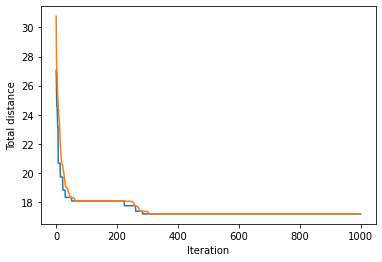

In [8]:
# 畫圖 
import matplotlib.pyplot

best_pos = np.zeros((NUM_ITERATION,), dtype=float)
mean_pos = np.zeros((NUM_ITERATION,), dtype=float)

for i in range(NUM_ITERATION):
  best_pos[i] = best_outputs[i] * (-1)
  mean_pos[i] = mean_outputs[i] * (-1)

matplotlib.pyplot.plot(best_pos)
matplotlib.pyplot.plot(mean_pos)
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Total distance")
matplotlib.pyplot.show()